In [88]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [89]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

train_f5 = pd.read_csv('../input/fe_train.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fe_test.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('../input/fi_train.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fi_test.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

res = pd.read_csv('./simple_offline23.csv', index_col='TransactionID')
train_transaction['pred'] = res['pred']
train_transaction['error'] = abs(train_transaction['isFraud'] - train_transaction['pred'])
# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]


test_transaction['isFraud'] = -1

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
train_transaction['pred']

CPU times: user 49.9 s, sys: 9.22 s, total: 59.1 s
Wall time: 1min 15s


TransactionID
2987000         NaN
2987001         NaN
2987002         NaN
2987003         NaN
2987004         NaN
2987005         NaN
2987006         NaN
2987007         NaN
2987008         NaN
2987009         NaN
2987010         NaN
2987011         NaN
2987012         NaN
2987013         NaN
2987014         NaN
2987015         NaN
2987016         NaN
2987017         NaN
2987018         NaN
2987019         NaN
2987020         NaN
2987021         NaN
2987022         NaN
2987023         NaN
2987024         NaN
2987025         NaN
2987026         NaN
2987027         NaN
2987028         NaN
2987029         NaN
             ...   
3577510    0.005367
3577511    0.000784
3577512    0.014234
3577513    0.000532
3577514    0.002578
3577515    0.007036
3577516    0.004074
3577517    0.011821
3577518    0.000624
3577519    0.002081
3577520    0.000485
3577521    0.000741
3577522    0.000400
3577523    0.001118
3577524    0.010700
3577525    0.000065
3577526    0.098376
3577527    0.001764
357752

In [ ]:
# train_f5 = pd.read_csv('../input/f5_train2.csv', index_col='TransactionID').iloc[:,:3]
# test_f5 = pd.read_csv('../input/f5_test2.csv', index_col='TransactionID').iloc[:,:3]
# train_f6 = pd.read_csv('../input/f5_train3.csv', index_col='TransactionID').iloc[:,:3]
# test_f6 = pd.read_csv('../input/f5_test3.csv', index_col='TransactionID').iloc[:,:3]

In [92]:
train = train_transaction.merge(train_identity , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity , how='left', left_index=True, right_index=True)

In [ ]:
card1= 16075
# col = train_transaction.groupby('card1')['card2'].nunique() 
# for card1 in col[col >= 2].index:
#     print(card1)
#     print(train_transaction[train_transaction['card1'] == card1]['card2'].value_counts())
#     print(train_transaction[train_transaction['card1'] == card1]['isFraud'].value_counts())
# print(train[train['card1']==15300][['hour','isFraud','TransactionAmt','uid']])

train_transaction['tempcount'] = train_transaction.groupby(['TransactionDT2','uid2','TransactionAmt'])['TransactionAmt'].transform('count') 
count1 = 0
count2 = 0
col_count = train_transaction.groupby(['TransactionDT2','uid2','TransactionAmt'])['isFraud'].transform('count')
col_count2 = train_transaction.groupby(['TransactionDT2','uid2','TransactionAmt'])['isFraud'].transform('sum')
for key in col_count2[col_count2 > 0].index:
    if col_count[key] > 1:
        count1 += 1
        if col_count2[key] != col_count[key]:
            count2 += 1
    
print(count1,count2)

In [12]:
for col in "addr1,addr2,card1,card2,card3,card4,card5,card6,TransactionAmt,M1,M2,M3,M4,M5,M6,M7,M8".split(","):
    s1 = set(train_transaction[col].fillna(-1).tolist())
    s2 = set(test_transaction[col].fillna(-1).tolist())
    print(col,len(s1),len(s2),len(s2-s1),len(s1-s2),test_transaction[test_transaction[col].map(lambda x:x not in s1 and x != np.nan)].shape[0])

addr1 333 293 109 149 65785
addr2 75 73 19 21 65656
card1 13553 13244 3538 3847 9360
card2 501 498 1 4 8794
card3 115 116 19 18 3048
card4 5 5 0 0 3086
card5 120 103 19 36 4601
card6 5 4 0 1 3007
TransactionAmt 20902 14119 8904 15687 15816
M1 3 3 0 0 176639
M2 3 3 0 0 176639
M3 3 3 0 0 176639
M4 4 4 0 0 237745
M5 3 3 0 0 309632
M6 3 3 0 0 158939
M7 3 3 0 0 235018
M8 3 3 0 0 235004


In [7]:
train_transaction['M4'].value_counts()

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

In [90]:
train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

train_transaction['uid3'] = train_transaction['uid'].astype(str)+'_'+train_transaction['P_emaildomain'].astype(str)
test_transaction['uid3'] = test_transaction['uid'].astype(str)+'_'+test_transaction['P_emaildomain'].astype(str)

train_transaction['uid3'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card5'].astype(str)+'_'+train_transaction['card6'].astype(str)
test_transaction['uid3'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card5'].astype(str)+'_'+test_transaction['card6'].astype(str)

train_transaction['D16'] = train_transaction['D15'] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['D16'] = test_transaction['D15'] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

print(train_transaction['uid'].value_counts())
print(train_transaction['uid3'].value_counts())
print(test_transaction['uid3'].value_counts())
# print(train_transaction['card1'].value_counts())
# print(train_transaction[train_transaction['card2']==111]['uid'].value_counts())
train_transaction2 = train_transaction.append(test_transaction)
train_transaction2['day'] = train_transaction2['TransactionDT'].map(lambda x:x//(3600*24))
train_transaction2['hour2'] = train_transaction2['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction2['hour'] = train_transaction2['TransactionDT'].map(lambda x:x//(3600))
train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:x//(3600))


# train_transaction[train_transaction['uid2']=='15885_545.0_185.0_visa_nan_nan'][['uid'] + ["D"+str(i+1) for i in range(15)]]

7919_194.0_150.0_mastercard           14891
9500_321.0_150.0_visa                 14112
15885_545.0_185.0_visa                10332
17188_321.0_150.0_visa                10312
15066_170.0_150.0_mastercard           7918
12695_490.0_150.0_visa                 7079
6019_583.0_150.0_visa                  6766
12544_321.0_150.0_visa                 6760
2803_100.0_150.0_visa                  6126
7585_553.0_150.0_visa                  5325
10616_583.0_150.0_visa                 5155
12839_321.0_150.0_visa                 5110
3154_408.0_185.0_mastercard            4604
18132_567.0_150.0_mastercard           4197
15497_490.0_150.0_visa                 3973
16132_111.0_150.0_visa                 3914
2884_490.0_150.0_visa                  3864
16075_514.0_150.0_mastercard           3739
11207_361.0_150.0_visa                 3677
10112_360.0_150.0_visa                 3546
7508_321.0_150.0_visa                  3474
2616_327.0_150.0_discover              3200
10057_225.0_150.0_mastercard    

In [97]:
# print(train_transaction[train_transaction['card1']==10175]['uid3'].value_counts())
# for i in range(339):
#     col = "V" + str(i+1)
#     print(col,train_transaction[col].isna().sum(),test_transaction[col].isna().sum())


# for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(','):
#     print(col,train[col].isna().sum(),test[col].isna().sum())
# for col in "D1,D15".split(','):
#     print(col,train[col].isna().sum(),test[col].isna().sum())  
    
# for p in "W,S,C,H,R".split(","):
#     print(p,(1 - train[train['ProductCD']==p][train['isFraud']==1]["pred"]).mean())
#     print((0 - train[train['ProductCD']==p]["pred"]).mean())
#     print(train[train['ProductCD']==p]['isFraud'].value_counts())
train[train['isFraud']>0].loc[:,['uid',"TransactionAmt","ProductCD",'isFraud',"pred","addr1","hour","D1","D2","D3","D5","V258","V70","V307","DeviceInfo","tempcount"]].iloc[-650:-600]

,uid,TransactionAmt,ProductCD,isFraud,pred,addr1,hour,D1,D2,D3,D5,V258,V70,V307,DeviceInfo,tempcount
TransactionID,,,,,,,,,,,,,,,,
3561876,3939_555.0_150.0_mastercard,97.000,W,1,0.534516,226.0,4243,112.0,112.0,64.0,NaN,NaN,0.0,0.000000,NaN,9
3561907,16659_170.0_150.0_visa,171.000,W,1,0.022762,315.0,4243,0.0,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,1
3561908,14290_512.0_150.0_visa,107.950,W,1,0.005846,225.0,4243,0.0,NaN,NaN,NaN,NaN,1.0,0.000000,NaN,1
3561930,9169_266.0_185.0_mastercard,33.199,C,1,0.275070,NaN,4244,0.0,NaN,NaN,0.0,2.0,0.0,0.000000,Blade A510 Build/MRA58K,1
3561934,9169_266.0_185.0_mastercard,33.199,C,1,0.150095,NaN,4244,0.0,NaN,0.0,0.0,2.0,0.0,33.199200,Blade A510 Build/MRA58K,1
3561940,12730_266.0_185.0_mastercard,33.199,C,1,0.237201,NaN,4244,0.0,NaN,0.0,0.0,2.0,0.0,33.199200,Blade A510 Build/MRA58K,1
3561944,12730_266.0_185.0_mastercard,33.199,C,1,0.206246,NaN,4244,0.0,NaN,0.0,0.0,2.0,0.0,66.398399,Blade A510 Build/MRA58K,1
3561949,12730_266.0_185.0_mastercard,33.199,C,1,0.182828,NaN,4244,0.0,NaN,0.0,0.0,2.0,0.0,99.597603,Blade A510 Build/MRA58K,1
3561990,15146_311.0_185.0_visa,118.287,C,1,0.973387,NaN,4244,0.0,NaN,NaN,1.0,NaN,0.0,0.000000,NaN,1


In [46]:
from sklearn.metrics import roc_auc_score
split_pos = train_transaction.shape[0]*4//5
df = train_transaction.iloc[split_pos:,:].copy()
y_test = df['isFraud']
y_pred = df['pred']
print(roc_auc_score(y_test,y_pred))

df.loc[df[df['ProductCD'] == "C"].index,'pred'] = df.loc[df[df['ProductCD'] == "C"].index,'pred'].map(lambda x:x**1.05)
print(roc_auc_score(y_test,y_pred))
for p in "W,S,C,H,R".split(","):
    print(p,df[df['ProductCD'] == p].shape,df[df['ProductCD'] == p]['TransactionAmt'].mean())
    print(roc_auc_score(df[df['ProductCD'] == p]['isFraud'],df[df['ProductCD'] == p]['pred']))
del df

0.9465381717741488
0.9463844827331459
W (93669, 404) 153.64123616137675
0.9273116274347684
S (3501, 404) 73.92473578977435
0.8917265322121101
C (12109, 404) 40.58755735403419
0.9443508037811181
H (3333, 404) 78.4956495649565
0.9276682119548326
R (5496, 404) 152.8566229985444
0.9770926373064036


In [87]:
# for col in ['card123456_add1_D2_series']:
#     vc = train_transaction[col].value_counts()
#     known_set = set(vc.index.tolist())
#     unknown_set = set(test_transaction[col].tolist())
# #     maxvalue =  max(train_transaction[col].max(),test_transaction[col].max()) + 1
#     print(col,len(known_set),len(unknown_set),len(unknown_set - known_set))

for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    print(train_transaction[col].mean(),test_transaction[col].mean(),col)

# train_transaction['card123456_add1_D2_series'].value_counts().value_counts()

94.34756843625429 108.20750409459514 D1
169.56323145317248 188.66662131052286 D2
28.343347718075332 33.39472704571585 D3
140.0024405978872 175.0607993672064 D4
42.33596485915518 50.97775188087108 D5
69.80571686228429 82.44314530024121 D6
41.63894955931855 61.8156419935809 D7
146.0581076468787 160.83448318487152 D8
123.98213667937759 159.81055194213855 D10
146.6214654959149 218.4148946158529 D11
54.03753264211876 77.40417881999596 D12
17.901294550619834 18.225961226739287 D13
57.724444015630276 58.16318558258243 D14
163.744578971615 206.8541370986329 D15


In [29]:
train.loc[[3517087,3517836],['uid',"TransactionAmt","isFraud","pred","addr1","hour","id_02","id_30","id_31","DeviceType","DeviceInfo","D15","D1","V258"]]

,uid,TransactionAmt,isFraud,pred,addr1,hour,id_02,id_30,id_31,DeviceType,DeviceInfo,D15,D1,V258
TransactionID,,,,,,,,,,,,,,
3517087,12695_490.0_150.0_visa,59.0,0,0.001352,325.0,3878,NaN,NaN,NaN,NaN,NaN,503.0,503.0,-1.0
3517836,12695_490.0_150.0_visa,226.0,1,0.401191,325.0,3882,NaN,NaN,NaN,NaN,NaN,503.0,503.0,-1.0


In [102]:
# print(train.groupby(['uid']).agg({'isFraud':['sum','mean'],'TransactionAmt':['sum','count','nunique']}).iloc[1050:1100])
train['hour2'] = train['TransactionDT'].map(lambda x:(x//3600)%24)
train['hour'] = train['TransactionDT'].map(lambda x:x//(3600))
# train['V70'] = train['V70'].fillna(-1)
print(train.groupby(['D15']).agg({'isFraud':['sum','mean','count']}).sort_index())

       isFraud                  
           sum      mean   count
D15                             
-83.0        0  0.000000       1
-74.0        0  0.000000       1
-60.0        0  0.000000       1
-53.0        0  0.000000       2
-30.0        0  0.000000       1
-29.0        0  0.000000       1
-28.0        0  0.000000       1
-15.0        0  0.000000       1
-13.0        0  0.000000       1
-6.0         0  0.000000       1
-3.0         0  0.000000       2
-2.0         0  0.000000       1
-1.0         0  0.000000       1
 0.0      7886  0.045258  174246
 1.0       716  0.120620    5936
 2.0       440  0.119209    3691
 3.0       265  0.092078    2878
 4.0       184  0.071512    2573
 5.0       178  0.076199    2336
 6.0       137  0.060193    2276
 7.0       134  0.051998    2577
 8.0       119  0.060314    1973
 9.0       111  0.063977    1735
 10.0       96  0.059443    1615
 11.0       80  0.051780    1545
 12.0       64  0.040302    1588
 13.0       75  0.041876    1791
 14.0     

In [212]:
xx = train_transaction[train_transaction['isFraud']==1].groupby(['uid']).agg({'TransactionAmt':['count']}).iloc[:,0]
xy = train_transaction.groupby(['uid']).agg({'isFraud':['mean','sum'],'TransactionAmt':['count'],'error':['sum','mean']})
xy[xy.iloc[:,1]>10].sort_index()
# xx.value_counts()
# train_transaction.groupby(['TransactionDT2','uid2','TransactionAmt'])['TransactionDT'].rank()

isFraud      TransactionAmt       error  \
                                  mean  sum          count         sum   
uid                                                                      
10011_319.0_150.0_visa        0.428571   39             91    0.020234   
10023_111.0_150.0_visa        0.017348   42           2421   13.018779   
10054_289.0_185.0_visa        0.556962   44             79    4.147891   
10057_225.0_150.0_mastercard  0.038571  122           3163   13.557634   
10086_500.0_185.0_mastercard  0.211364   93            440    4.955777   
10112_360.0_150.0_visa        0.009588   34           3546    5.949045   
10175_176.0_185.0_visa        0.625000   45             72    4.331163   
10186_417.0_150.0_visa        0.043182   19            440    0.678133   
10369_176.0_185.0_mastercard  0.339506   55            162    4.971453   
10486_514.0_150.0_mastercard  0.056310  141           2504   28.263509   
10568_204.0_185.0_visa        0.206074  190            922   37.928275   
10616_583.0_150.0_visa        0.038991  201           5155   45.839693   
10682_514.0_150.0_mastercard  0.131148   32            244    4.435155   
10736_130.0_185.0_visa        0.439024   18             41    0.921034   
1078_512.0_150.0_visa         0.020270   12            592    0.864013   
10836_537.0_150.0_mastercard  0.068182   12            176    0.091791   
10859_231.0_150.0_mastercard  0.057971   16            276    1.317604   
1085_500.0_185.0_mastercard   0.161157   39            242    1.765645   
10876_104.0_185.0_visa        0.248663  186            748   11.606468   
10925_543.0_150.0_mastercard  0.060465   13            215    7.251603   
10960_567.0_150.0_mastercard  0.027579   27            979    9.565337   
11106_100.0_150.0_visa        0.021780   23           1056    2.106699   
11157_215.0_150.0_visa        0.015187   26           1712    4.001394   
11162_346.0_150.0_mastercard  0.038636   34            880   13.655747   
11167_211.0_150.0_mastercard  0.322034   19             59    0.072005   
11201_103.0_185.0_visa        0.085029  117           1376   13.277261   
11207_361.0_150.0_visa        0.011694   43           3677   10.554956   
11218_579.0_150.0_visa        0.043887   42            957    4.259116   
11233_321.0_150.0_visa        0.082077   49            597    2.920092   
11279_354.0_143.0_visa        0.100000   11            110    0.157953   
...                                ...  ...            ...         ...   
8528_215.0_150.0_visa         0.015769   24           1522    3.442279   
8695_170.0_150.0_visa         0.034031   39           1146    8.009441   
8755_500.0_185.0_mastercard   0.178928  197           1101   21.649724   
8801_512.0_150.0_mastercard   0.733333   11             15    0.000000   
8868_205.0_150.0_visa         0.031683   16            505    0.951901   
9002_453.0_150.0_visa         0.114259  121           1059   11.195543   
9026_545.0_185.0_visa         0.191582  396           2067   49.076841   
9043_170.0_150.0_visa         0.029973   11            367    0.592204   
9082_141.0_185.0_visa         0.230263   35            152    3.175995   
9112_250.0_150.0_visa         0.014824   35           2361    8.016502   
9169_266.0_185.0_mastercard   0.464286   13             28    2.052111   
9175_111.0_150.0_visa         0.019811   23           1161    2.767968   
9300_103.0_185.0_visa         0.047257   56           1185   14.621332   
9350_111.0_150.0_visa         0.029255   22            752    1.032346   
9364_225.0_150.0_mastercard   0.107784   18            167    0.125675   
9375_536.0_150.0_visa         0.594595   22             37    0.000484   
9387_500.0_185.0_mastercard   0.263158   15             57    0.132493   
9400_111.0_150.0_mastercard   0.029888   24            803    6.547962   
9480_170.0_150.0_visa         0.017172   17            990    3.555466   
9499_555.0_150.0_visa         0.694444   25             36    2.203731   
9500_321.0_150.0_visa         0.037

In [108]:

train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

for col in [['TransactionDT2','uid2','TransactionAmt']]: 
# for col in [['card123456_add1_D2_series']]: 

    train_transaction['tempcount'] = train_transaction.groupby(col)['TransactionAmt'].transform('count')
    

# print(train_transaction[train_transaction['tempcount'] > 1].shape,train_transaction[train_transaction['tempcount'] > 1]['isFraud'].sum())
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:x//(3600))
train_transaction[train_transaction['tempcount'] >4 ][train_transaction['isFraud'] ==1 ][['uid','isFraud','pred','hour','hour2','P_emaildomain','TransactionAmt','addr1','tempcount'] + ["D1","C1","V307",'D2','D3',"D15",'card123456_add1_D2_series']].iloc[-200:-150]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,uid,isFraud,pred,hour,hour2,P_emaildomain,TransactionAmt,addr1,tempcount,D1,C1,V307,D2,D3,D15,card123456_add1_D2_series
TransactionID,,,,,,,,,,,,,,,,
3540104,14426_111.0_150.0_mastercard,1,0.116253,4057,1,gmail.com,59.000,272.0,8,37.0,1.0,1442.000000,37.0,0.0,33.0,14426_111.0_150.0_mastercard_224.0_debit_272.0...
3540109,2581_445.0_150.0_mastercard,1,0.070380,4057,1,yahoo.com,29.000,315.0,5,41.0,2.0,435.000000,2.0,0.0,457.0,2581_445.0_150.0_mastercard_166.0_debit_315.0_5.0
3540616,9642_103.0_185.0_visa,1,0.932757,4067,11,gmail.com,22.993,NaN,7,5.0,13.0,62.587200,NaN,5.0,5.0,9642_103.0_185.0_visa_226.0_debit_nan_69.0
3540663,9633_130.0_185.0_visa,1,0.971341,4067,11,gmail.com,22.993,NaN,12,5.0,13.0,62.587200,NaN,5.0,5.0,9633_130.0_185.0_visa_138.0_debit_nan_1803.0
3540974,7826_481.0_150.0_mastercard,1,0.001903,4070,14,gmail.com,107.950,387.0,5,42.0,1.0,215.899994,28.0,14.0,42.0,7826_481.0_150.0_mastercard_224.0_debit_387.0_...
3541008,9642_103.0_185.0_visa,1,0.922372,4070,14,gmail.com,22.993,NaN,7,2.0,13.0,33.260700,NaN,3.0,5.0,9642_103.0_185.0_visa_226.0_debit_nan_70.0
3541013,9633_130.0_185.0_visa,1,0.980609,4070,14,gmail.com,22.993,NaN,12,0.0,14.0,0.000000,NaN,NaN,5.0,9633_130.0_185.0_visa_138.0_debit_nan_1806.0
3541048,2581_445.0_150.0_mastercard,1,0.065938,4070,14,yahoo.com,29.000,315.0,5,41.0,2.0,488.000000,2.0,1.0,458.0,2581_445.0_150.0_mastercard_166.0_debit_315.0_5.0
3541202,2581_445.0_150.0_mastercard,1,0.064298,4071,15,yahoo.com,29.000,315.0,5,41.0,2.0,517.000000,2.0,0.0,458.0,2581_445.0_150.0_mastercard_166.0_debit_315.0_5.0


In [70]:
a = train_transaction.groupby(['card123456_add1_D2_series'])['isFraud'].std()
a[a>0]

card123456_add1_D2_series
10023_111.0_150.0_visa_226.0_debit_325.0_11.0          0.408248
10023_111.0_150.0_visa_226.0_debit_325.0_169.0         0.408248
10023_111.0_150.0_visa_226.0_debit_325.0_180.0         0.707107
10023_111.0_150.0_visa_226.0_debit_325.0_195.0         0.547723
10023_111.0_150.0_visa_226.0_debit_325.0_56.0          0.577350
10057_225.0_150.0_mastercard_224.0_debit_123.0_35.0    0.427793
10057_225.0_150.0_mastercard_224.0_debit_123.0_97.0    0.353553
10057_225.0_150.0_mastercard_224.0_debit_269.0_7.0     0.179605
10086_500.0_185.0_mastercard_224.0_credit_nan_11.0     0.500000
10086_500.0_185.0_mastercard_224.0_credit_nan_2.0      0.547723
10086_500.0_185.0_mastercard_224.0_credit_nan_25.0     0.577350
10112_360.0_150.0_visa_166.0_debit_205.0_6.0           0.500000
10112_360.0_150.0_visa_166.0_debit_299.0_40.0          0.577350
10112_360.0_150.0_visa_166.0_debit_299.0_46.0          0.577350
10447_490.0_150.0_visa_226.0_debit_315.0_8.0           0.333333
10505_567.0_15

In [81]:
train_transaction[train_transaction['card123456_add1_D2_series']=='10057_225.0_150.0_mastercard_224.0_debit_269.0_7.0'][['uid','pred','isFraud','P_emaildomain','TransactionAmt','addr1','D2','D3','D4','D10','D15']]

# test_transaction[test_transaction['card123456_add1_D2_series']=='18227_583.0_150.0_visa_226.0_credit_181.0_1.0'][['uid','isFraud','P_emaildomain','TransactionAmt','addr1','D2']]

,uid,pred,isFraud,P_emaildomain,TransactionAmt,addr1,D2,D3,D4,D10,D15
TransactionID,,,,,,,,,,,
3161354,10057_225.0_150.0_mastercard,NaN,1,NaN,29.00,269.0,1.0,2.0,NaN,2.0,2.0
3161900,10057_225.0_150.0_mastercard,NaN,0,yahoo.com,97.00,269.0,1.0,1.0,422.0,131.0,422.0
3164165,10057_225.0_150.0_mastercard,NaN,1,NaN,24.00,269.0,2.0,1.0,NaN,3.0,3.0
3164191,10057_225.0_150.0_mastercard,NaN,1,NaN,24.00,269.0,2.0,0.0,NaN,3.0,3.0
3164234,10057_225.0_150.0_mastercard,NaN,1,NaN,15.00,269.0,2.0,0.0,NaN,3.0,3.0
3164265,10057_225.0_150.0_mastercard,NaN,1,NaN,15.00,269.0,2.0,0.0,NaN,3.0,3.0
3164275,10057_225.0_150.0_mastercard,NaN,1,bellsouth.net,15.00,269.0,2.0,0.0,78.0,3.0,3.0
3182027,10057_225.0_150.0_mastercard,NaN,1,bellsouth.net,29.00,269.0,8.0,6.0,84.0,9.0,9.0
3198893,10057_225.0_150.0_mastercard,NaN,1,bellsouth.net,24.00,269.0,14.0,6.0,90.0,15.0,15.0


In [61]:
train_transaction[train_transaction['uid']=='5376_111.0_150.0_mastercard'][['uid','isFraud','pred','ProductCD','hour','hour2','R_emaildomain','P_emaildomain','TransactionAmt','addr1'] + ["D4","D9","D15","D16","C1","C5","V307",'V310','V127']]
# train_transaction2[train_transaction2['hour']<=1000][train_transaction2['TransactionAmt']==39.0][train_transaction2['addr1']==325.0][['uid','isFraud','ProductCD','hour','R_emaildomain','P_emaildomain','TransactionAmt','addr1','dist1'] + ["C"+str(i+1) for i in range(14)]]

,uid,isFraud,pred,ProductCD,hour,hour2,R_emaildomain,P_emaildomain,TransactionAmt,addr1,D4,D9,D15,D16,C1,C5,V307,V310,V127
TransactionID,,,,,,,,,,,,,,,,,,,
2994828,5376_111.0_150.0_mastercard,0,NaN,W,67,19,NaN,NaN,50.00,325.0,NaN,NaN,99.0,97.0,1.0,0.0,350.000000,250.000000,0.000000
2996414,5376_111.0_150.0_mastercard,0,NaN,W,74,2,NaN,anonymous.com,210.95,441.0,NaN,NaN,NaN,NaN,135.0,103.0,0.000000,0.000000,0.000000
2996753,5376_111.0_150.0_mastercard,0,NaN,W,82,10,NaN,NaN,107.95,325.0,NaN,NaN,481.0,478.0,3.0,1.0,0.000000,0.000000,250.000000
3004995,5376_111.0_150.0_mastercard,0,NaN,W,136,16,NaN,NaN,50.00,325.0,NaN,NaN,127.0,122.0,2.0,0.0,100.000000,100.000000,100.000000
3007663,5376_111.0_150.0_mastercard,0,NaN,W,146,2,NaN,NaN,50.00,325.0,NaN,NaN,218.0,212.0,20.0,14.0,100.000000,100.000000,100.000000
3009088,5376_111.0_150.0_mastercard,0,NaN,W,161,17,NaN,NaN,50.00,325.0,NaN,NaN,103.0,97.0,1.0,0.0,400.000000,300.000000,350.000000
3011352,5376_111.0_150.0_mastercard,0,NaN,W,170,2,NaN,NaN,50.00,325.0,NaN,NaN,219.0,212.0,20.0,14.0,150.000000,150.000000,150.000000
3012745,5376_111.0_150.0_mastercard,0,NaN,W,185,17,NaN,NaN,50.00,325.0,NaN,NaN,220.0,213.0,20.0,14.0,200.000000,200.000000,200.000000
3019664,5376_111.0_150.0_mastercard,0,NaN,W,226,10,NaN,NaN,67.95,325.0,NaN,NaN,221.0,212.0,208.0,123.0,250.000000,250.000000,250.000000


In [261]:
# train = train_transaction.merge(train_identity , how='left', left_index=True, right_index=True)
train_transaction[train_transaction['uid']=='18227_583.0_150.0_visa'][['uid','isFraud','pred','ProductCD','hour','R_emaildomain','P_emaildomain','TransactionAmt','addr1','tempcount'] + ["D4","D15","C1","V264","V307",'V306','V308']]

,uid,isFraud,pred,ProductCD,hour,R_emaildomain,P_emaildomain,TransactionAmt,addr1,tempcount,D4,D15,C1,V264,V307,V306,V308
TransactionID,,,,,,,,,,,,,,,,,
2987131,18227_583.0_150.0_visa,0,NaN,W,24,NaN,gmail.com,444.61,325.0,1,0.0,0.0,1.0,NaN,0.000000,0.000000,0.000000
2987175,18227_583.0_150.0_visa,0,NaN,W,24,NaN,hotmail.com,117.00,325.0,1,0.0,0.0,1.0,NaN,0.000000,0.000000,0.000000
2987937,18227_583.0_150.0_visa,0,NaN,W,30,NaN,sbcglobal.net,300.00,299.0,1,10.0,10.0,1.0,NaN,5125.000000,0.000000,3415.000000
2988768,18227_583.0_150.0_visa,0,NaN,S,38,gmail.com,NaN,75.00,441.0,3,NaN,0.0,1.0,0.0,0.000000,0.000000,0.000000
2989618,18227_583.0_150.0_visa,0,NaN,H,41,NaN,me.com,100.00,310.0,2,NaN,NaN,1.0,0.0,0.000000,0.000000,0.000000
2989621,18227_583.0_150.0_visa,0,NaN,H,41,NaN,me.com,100.00,310.0,2,NaN,NaN,1.0,100.0,100.000000,100.000000,100.000000
2989861,18227_583.0_150.0_visa,0,NaN,H,41,yahoo.com,yahoo.com,75.00,204.0,1,NaN,NaN,1.0,0.0,0.000000,0.000000,0.000000
2991615,18227_583.0_150.0_visa,0,NaN,W,46,NaN,verizon.net,34.00,325.0,1,NaN,NaN,1.0,NaN,0.000000,0.000000,0.000000
2993686,18227_583.0_150.0_visa,0,NaN,W,63,NaN,yahoo.com,300.00,170.0,1,466.0,475.0,5.0,NaN,200.000000,0.000000,200.000000


In [84]:
train_transaction2['hour'] = train_transaction2['TransactionDT'].map(lambda x:(x//3600))
train_transaction2['D16'] = train_transaction2['D15'] - train_transaction2['hour']//24
train_transaction2[train_transaction2['uid3']=='9500_321.0_150.0_visa_gmail.com'][['isFraud','TransactionAmt','hour','addr1'] + ["D"+str(i+1) for i in range(16)]]
# train_transaction[train_transaction['isFraud']==1][['isFraud','uid','TransactionAmt','hour'] + ["D"+str(i+1) for i in range(16)]].iloc[500:600]
train_transaction2[train_transaction2['TransactionAmt']==70.702][train_transaction2['uid']=='3154_408.0_185.0_mastercard'][['isFraud','uid','TransactionAmt','hour','addr1'] + ["D"+str(i+1) for i in range(16)]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,isFraud,uid,TransactionAmt,hour,addr1,D1,D2,D3,D4,D5,...,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16
TransactionID,,,,,,,,,,,,,,,,,,,,,
3443765,0,3154_408.0_185.0_mastercard,70.702,3242,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3450246,1,3154_408.0_185.0_mastercard,70.702,3309,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.875000,0.875000,0.0,NaN,0.0,0.0,NaN,0.0,-137.0
3450254,1,3154_408.0_185.0_mastercard,70.702,3309,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.875000,0.875000,0.0,NaN,0.0,0.0,NaN,0.0,-137.0
3457640,0,3154_408.0_185.0_mastercard,70.702,3376,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,-140.0
3457660,0,3154_408.0_185.0_mastercard,70.702,3376,NaN,0.0,NaN,0.0,0.0,0.0,...,0.0,0.666666,0.666666,0.0,NaN,0.0,0.0,0.0,0.0,-140.0
3537477,0,3154_408.0_185.0_mastercard,70.702,4036,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,-168.0
3546457,0,3154_408.0_185.0_mastercard,70.702,4119,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,-171.0
3570653,1,3154_408.0_185.0_mastercard,70.702,4336,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,99.666664,0.666666,0.0,NaN,0.0,20.0,NaN,20.0,-160.0
3765274,-1,3154_408.0_185.0_mastercard,70.702,6063,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,-252.0


In [80]:
train_transaction2[train_transaction2['uid']=='10859_231.0_150.0_mastercard'][['isFraud','ProductCD','hour','R_emaildomain','P_emaildomain','TransactionAmt','addr1','dist1'] + ["C"+str(i+1) for i in range(14)]]

,isFraud,ProductCD,hour,R_emaildomain,P_emaildomain,TransactionAmt,addr1,dist1,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2989237,0,W,40,NaN,att.net,117.00,251.0,0.0,2.0,2.0,...,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,2.0
2991079,0,W,45,NaN,NaN,50.00,251.0,NaN,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,26.0,1.0
2996694,1,W,79,NaN,gmail.com,87.00,433.0,156.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2998504,0,W,93,NaN,yahoo.com,20.00,272.0,NaN,3.0,3.0,...,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,31.0,3.0
2999276,0,W,96,NaN,gmail.com,150.00,204.0,NaN,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,24.0,2.0
3012134,0,W,182,NaN,gmail.com,213.00,251.0,8.0,2.0,3.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,6.0,2.0
3013248,0,W,186,NaN,gmail.com,29.00,191.0,863.0,1.0,1.0,...,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
3024651,0,W,259,NaN,gmail.com,71.95,251.0,NaN,1.0,3.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,1.0
3024660,0,W,259,NaN,yahoo.com,83.00,251.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0


In [81]:
train_transaction2[train_transaction2['uid']=='9500_321.0_150.0_visa'][['isFraud','ProductCD','hour','R_emaildomain','P_emaildomain','TransactionAmt','addr1'] + ["C"+str(i+1) for i in range(14)]]

,isFraud,ProductCD,hour,R_emaildomain,P_emaildomain,TransactionAmt,addr1,C1,C2,C3,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987107,0,W,24,NaN,aol.com,226.00,204.0,3.0,3.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,8.0,2.0
2987122,0,W,24,NaN,NaN,80.00,325.0,21.0,25.0,0.0,...,33.0,22.0,0.0,0.0,17.0,0.0,19.0,0.0,99.0,18.0
2987161,0,W,24,NaN,gmail.com,107.95,204.0,1.0,1.0,0.0,...,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0
2987174,0,W,24,NaN,gmail.com,107.95,204.0,3.0,3.0,0.0,...,7.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,31.0,3.0
2987225,0,W,24,NaN,aol.com,43.00,126.0,2.0,1.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,7.0,2.0
2987255,0,W,25,NaN,hotmail.com,54.00,204.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2987332,0,R,25,anonymous.com,gmail.com,100.00,251.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2987335,0,R,25,anonymous.com,gmail.com,100.00,251.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2987336,0,R,25,anonymous.com,gmail.com,100.00,251.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [98]:
train_transaction[train_transaction['C2']>400][train_transaction['C2'] < 1000][train_transaction['TransactionDT'] > 10000000][train_transaction['TransactionDT'] < 14000000][['isFraud','uid','TransactionAmt','addr1'] + ["V"+str(i+75) for i in range(14)]].iloc[:100]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,isFraud,uid,TransactionAmt,addr1,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88
TransactionID,,,,,,,,,,,,,,,,,,
3400086,1,5365_177.0_185.0_mastercard,127.244,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401018,1,14076_545.0_185.0_visa,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401021,1,8755_500.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401029,1,8680_228.0_106.0_visa,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401037,1,4504_500.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401043,1,4461_375.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401277,1,10368_555.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401282,1,4504_500.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3401287,1,3154_408.0_185.0_mastercard,84.830,NaN,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0


In [232]:
k1 = "9633_130.0_185.0_visa"
k2 = "5812_408.0_185.0_mastercard"

cachea = train_transaction[train_transaction['uid']==k1][['hour','TransactionAmt']].values
cacheb = train_transaction[train_transaction['uid']==k2][['hour','TransactionAmt','isFraud']].values
ad = {}
bd = {}
for i in range(cachea.shape[0]):
    hour = int(cachea[i,0])
    amt = float(cachea[i,1])
    ad[amt] = ad.get(amt,set())
    ad[amt].add(hour)
    
s = 0
c = 0
for i in range(cacheb.shape[0]):
    hour = int(cacheb[i,0])
    amt = float(cacheb[i,1])
    isfraud = cacheb[i,2]
    if ad.get(amt,-1)!= -1:
        if np.min(list(map(lambda x: abs(x - hour),ad[amt]))) < 100:
            print(amt,isfraud,hour,ad[amt])
            s += isfraud
            c += 1

print(s/c,train_transaction[train_transaction['uid']==k2]['isFraud'].mean())


28.397 0.0 74 {2352, 89}
33.534 1.0 89 {2274, 2499, 1828, 1829, 2450, 2546, 88, 2521, 2525, 1823}
17.522000000000002 0.0 169 {2584, 2780, 2524, 92}
31.191 0.0 207 {208, 360, 359}
31.191 0.0 218 {208, 360, 359}
31.191 0.0 257 {208, 360, 359}
31.191 0.0 257 {208, 360, 359}
56.551 1.0 279 {196}
56.551 1.0 279 {196}
119.399 0.0 425 {425}
33.814 0.0 474 {452, 453, 454, 455, 3797}
28.8 0.0 575 {599}
42.777 0.0 1672 {1745, 2562}
51.478 1.0 1725 {2010, 1725}
11.963 0.0 1750 {1842, 2099, 2308}
36.614000000000004 0.0 1750 {2758, 2790, 2774, 2779, 2780, 1822}
42.777 0.0 1766 {1745, 2562}
42.777 0.0 1769 {1745, 2562}
51.478 0.0 1773 {2010, 1725}
21.026 0.0 1802 {1867, 2694}
11.359000000000002 0.0 1829 {2731, 1895}
11.359000000000002 0.0 1829 {2731, 1895}
11.359000000000002 0.0 1829 {2731, 1895}
11.963 0.0 1830 {1842, 2099, 2308}
11.963 0.0 1836 {1842, 2099, 2308}
11.48 0.0 1864 {1920, 1986, 2280, 1963, 1875}
30.089000000000002 0.0 1876 {1877}
22.718000000000004 0.0 1885 {2632, 2165, 1820, 1869}
23

0.16071428571428573 0.11162460007109846


In [235]:
print(train_transaction['isFraud'].mean(),train_transaction[train_transaction['R_emaildomain']!=train_transaction['P_emaildomain']]['isFraud'].mean())

0.03499000914417313 0.02207009318984665


In [4]:
import pickle
f = open('mail_columns_ProNE_32.pickle','rb')
f_prone = pickle.loads(f.read()) 
f.close()
del f_prone['TransactionID']
print(f_prone.shape)

f_prone_train = f_prone.iloc[:train_transaction.shape[0]]
f_prone_train.index = train_transaction.index
f_prone_test = f_prone.iloc[train_transaction.shape[0]:]
f_prone_test.index = test_transaction.index
f_prone_col = f_prone.columns
print(f_prone.columns)

(1097231, 32)
Index(['mail_columns_ProNE_Emb_0', 'mail_columns_ProNE_Emb_1',
       'mail_columns_ProNE_Emb_2', 'mail_columns_ProNE_Emb_3',
       'mail_columns_ProNE_Emb_4', 'mail_columns_ProNE_Emb_5',
       'mail_columns_ProNE_Emb_6', 'mail_columns_ProNE_Emb_7',
       'mail_columns_ProNE_Emb_8', 'mail_columns_ProNE_Emb_9',
       'mail_columns_ProNE_Emb_10', 'mail_columns_ProNE_Emb_11',
       'mail_columns_ProNE_Emb_12', 'mail_columns_ProNE_Emb_13',
       'mail_columns_ProNE_Emb_14', 'mail_columns_ProNE_Emb_15',
       'mail_columns_ProNE_Emb_16', 'mail_columns_ProNE_Emb_17',
       'mail_columns_ProNE_Emb_18', 'mail_columns_ProNE_Emb_19',
       'mail_columns_ProNE_Emb_20', 'mail_columns_ProNE_Emb_21',
       'mail_columns_ProNE_Emb_22', 'mail_columns_ProNE_Emb_23',
       'mail_columns_ProNE_Emb_24', 'mail_columns_ProNE_Emb_25',
       'mail_columns_ProNE_Emb_26', 'mail_columns_ProNE_Emb_27',
       'mail_columns_ProNE_Emb_28', 'mail_columns_ProNE_Emb_29',
       'mail_columns_

In [5]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,card2,addr1".split(","):
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])

# for col in "TransactionDT".split(","):
#     print(col)
#     for i in range(24):
#         train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].map(lambda x:(x)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT"+"_"+str(int(x)),[0]*24)[i])
#         train_transaction["w2v_"+col+"2_"+str(i)] = train_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])
#         test_transaction["w2v_"+col+"2_"+str(i)] = test_transaction[col].map(lambda x:(x+3600*24*3.5)//(3600*24*7)).map(lambda x:embeddings_dict.get("TransactionDT2"+"_"+str(int(x)),[0]*24)[i])


TransactionDT_0 0
TransactionDT2_0 1
card1_13926 2
addr1_315 3
card2_-1 4
P_emaildomain_-1 5
card1_2755 6
addr1_325 7
card2_404 8
P_emaildomain_gmail.com 9
card1_4663 10
addr1_330 11
card2_490 12
P_emaildomain_outlook.com 13
card1_18132 14
addr1_476 15
card2_567 16
P_emaildomain_yahoo.com 17
card1_4497 18
addr1_420 19
card2_514 20
card1_5937 21
addr1_272 22
card2_555 23
card1_12308 24
addr1_126 25
card2_360 26
card1_12695 27
P_emaildomain_mail.com 28
card1_2803 29
addr1_337 30
card2_100 31
P_emaildomain_anonymous.com 32
card1_17399 33
addr1_204 34
card2_111 35
card1_16496 36
addr1_-1 37
card2_352 38
card1_4461 39
card2_375 40
P_emaildomain_hotmail.com 41
card1_3786 42
card2_418 43
P_emaildomain_verizon.net 44
card1_12866 45
card2_303 46
P_emaildomain_aol.com 47
card1_11839 48
addr1_226 49
card1_7055 50
card1_1790 51
addr1_170 52
card1_11492 53
addr1_184 54
card1_7005 55
addr1_264 56
card1_7875 57
addr1_299 58
card2_314 59
card1_11401 60
card2_543 61
card1_1724 62
card2_583 63
card1_239

card1_16483 1106
card1_6276 1107
card2_280 1108
card1_11344 1109
card1_15528 1110
card1_2695 1111
card1_1359 1112
card1_15111 1113
card1_11100 1114
card1_16777 1115
card1_9178 1116
card1_6556 1117
card1_5295 1118
card2_510 1119
card1_14618 1120
card1_3941 1121
card1_6635 1122
card2_426 1123
card1_7648 1124
card2_357 1125
card1_7856 1126
card1_1877 1127
card1_10854 1128
card2_593 1129
card1_12105 1130
card1_14131 1131
card2_467 1132
card1_9839 1133
card1_17541 1134
card1_14482 1135
card1_2744 1136
card1_18201 1137
card1_2234 1138
card1_14441 1139
card1_5635 1140
card1_7292 1141
card2_262 1142
card1_17939 1143
card1_8113 1144
card2_160 1145
card1_17469 1146
card1_6070 1147
card2_315 1148
card1_5355 1149
card1_3605 1150
card1_16709 1151
card1_2408 1152
card2_571 1153
card1_14186 1154
card2_394 1155
card1_13381 1156
card2_166 1157
card1_4658 1158
card1_15399 1159
card1_5698 1160
card1_1357 1161
card1_2939 1162
card1_12099 1163
card1_11837 1164
card2_304 1165
P_emaildomain_gmx.de 1166
card1

card1_16752 2188
card2_493 2189
card1_17832 2190
card1_15596 2191
card1_8335 2192
card1_4229 2193
card1_14310 2194
card1_13910 2195
card1_6968 2196
card1_9357 2197
card1_2300 2198
card2_412 2199
card1_2827 2200
card1_18035 2201
card1_11808 2202
card1_15466 2203
card1_8380 2204
card1_8953 2205
card1_2960 2206
card1_2947 2207
card2_380 2208
card1_6081 2209
card1_16072 2210
card2_473 2211
card1_4932 2212
card1_3569 2213
card1_4456 2214
card1_4225 2215
card1_2833 2216
card1_11902 2217
card1_9231 2218
card1_7790 2219
card1_18342 2220
card1_8423 2221
card1_3851 2222
card1_14249 2223
card1_14332 2224
card1_13674 2225
card1_4238 2226
card2_153 2227
card1_10706 2228
card1_16807 2229
card1_12065 2230
card2_575 2231
card1_5219 2232
card1_3029 2233
card1_6856 2234
card1_15128 2235
card2_190 2236
card1_10582 2237
card1_14610 2238
card2_495 2239
card1_1387 2240
card1_7148 2241
card1_9856 2242
card1_11148 2243
card1_2764 2244
card1_12996 2245
card1_6751 2246
card2_289 2247
card1_15397 2248
card2_465 

card1_6700 2754
card1_15084 2755
card1_5977 2756
card1_18103 2757
card2_288 2758
card1_12876 2759
card1_17670 2760
card1_18195 2761
card1_10210 2762
card2_279 2763
card1_8788 2764
card1_7036 2765
card1_6835 2766
card1_15372 2767
card2_241 2768
card1_13921 2769
card1_16221 2770
card1_12566 2771
card1_2627 2772
card1_8661 2773
card1_15016 2774
card1_1588 2775
card1_13709 2776
card1_3685 2777
card1_7202 2778
card1_3327 2779
card1_7078 2780
card1_15882 2781
card1_6516 2782
card1_7554 2783
card1_12766 2784
card1_14998 2785
card1_12629 2786
card1_12133 2787
card1_3475 2788
card1_8474 2789
card1_4336 2790
card1_8322 2791
card1_5182 2792
card1_17523 2793
card1_9237 2794
card1_1409 2795
card1_9959 2796
card1_1404 2797
card1_12751 2798
card1_10401 2799
card1_14171 2800
card1_8829 2801
card1_11445 2802
card1_2950 2803
card1_13836 2804
card1_17171 2805
card1_2046 2806
card1_2528 2807
card1_13045 2808
card1_9543 2809
card1_15119 2810
card1_15457 2811
card1_9938 2812
card1_13162 2813
card1_5625 2814

card1_5670 3833
card1_10332 3834
card1_15874 3835
card1_17662 3836
card1_18030 3837
card1_9995 3838
card1_13393 3839
card1_5431 3840
card1_1313 3841
card1_15738 3842
card1_16901 3843
card1_11980 3844
card1_15540 3845
card1_11019 3846
card1_7407 3847
card1_9684 3848
card1_13978 3849
card1_2948 3850
card1_15479 3851
card1_3574 3852
card2_232 3853
card1_8033 3854
addr1_198 3855
card1_1659 3856
card1_1225 3857
card1_14335 3858
card1_17564 3859
card1_9071 3860
card1_8069 3861
card1_14881 3862
card1_8416 3863
card1_5663 3864
card2_403 3865
card1_17111 3866
card1_11434 3867
addr1_162 3868
card1_6140 3869
card1_13690 3870
card1_3663 3871
card1_10225 3872
card1_18272 3873
card1_10618 3874
card1_11983 3875
card1_13642 3876
card1_9921 3877
card1_5004 3878
card1_7099 3879
card1_14835 3880
card1_11464 3881
card1_6520 3882
card1_16034 3883
card1_9565 3884
card1_8101 3885
card1_17050 3886
card1_14616 3887
card1_7324 3888
card1_5691 3889
card1_16341 3890
card1_6445 3891
card1_13630 3892
card1_5245 389

card1_10743 4866
card1_4973 4867
card1_15427 4868
card1_8753 4869
card1_13523 4870
card1_13183 4871
addr1_314 4872
card1_4822 4873
card1_1869 4874
card1_12827 4875
card1_13414 4876
card1_13062 4877
card1_1161 4878
card1_2732 4879
card1_1713 4880
card1_15487 4881
card1_6977 4882
card1_15683 4883
card1_3612 4884
card1_13687 4885
card1_2997 4886
card1_14654 4887
card1_1503 4888
card1_15122 4889
card1_8676 4890
card1_7721 4891
card1_1599 4892
card1_10351 4893
card1_14958 4894
card1_8578 4895
card1_2445 4896
addr1_445 4897
card1_3275 4898
card1_9142 4899
card1_7121 4900
card1_3292 4901
card1_8981 4902
card1_7440 4903
card1_7510 4904
card1_3319 4905
card1_3351 4906
card1_14163 4907
addr1_252 4908
card1_15489 4909
card1_2822 4910
card1_10018 4911
card1_12179 4912
card1_15728 4913
card1_3719 4914
card1_3700 4915
card1_4334 4916
card1_7983 4917
card1_6761 4918
card1_13999 4919
card1_14670 4920
card1_3903 4921
card1_4437 4922
card1_15763 4923
card1_15249 4924
card1_1628 4925
card1_6275 4926
card

card1_6787 5979
card1_15956 5980
addr1_416 5981
card1_15302 5982
addr1_528 5983
card1_15791 5984
card1_2355 5985
card1_8816 5986
card1_13129 5987
card1_8043 5988
addr1_112 5989
card1_15278 5990
card1_1141 5991
card1_9587 5992
card1_8112 5993
card1_4628 5994
card1_10317 5995
card1_14553 5996
card1_10784 5997
card1_8646 5998
card1_12717 5999
card1_17065 6000
card1_3149 6001
card1_13311 6002
card1_15493 6003
card1_15559 6004
addr1_219 6005
card1_15308 6006
card1_4071 6007
card1_6354 6008
card1_7184 6009
card1_9108 6010
card1_5193 6011
card1_3756 6012
card1_14625 6013
card1_13808 6014
card1_5408 6015
card1_14074 6016
card1_4728 6017
card1_10878 6018
card1_10464 6019
card1_7077 6020
card1_16019 6021
card1_2754 6022
card1_17841 6023
card1_11245 6024
card1_9993 6025
card1_10251 6026
card1_8841 6027
addr1_462 6028
card1_15358 6029
card1_17406 6030
card1_15173 6031
card1_6487 6032
card1_8784 6033
card1_10254 6034
card1_3046 6035
card1_2491 6036
card1_11373 6037
card1_1375 6038
card1_4957 6039
c

card1_15267 6979
card1_3575 6980
card1_11750 6981
card1_15498 6982
card1_16148 6983
card1_12152 6984
card1_10964 6985
card1_9169 6986
card1_15608 6987
card1_14303 6988
card1_2259 6989
card1_12679 6990
card1_17024 6991
card1_9032 6992
card1_8984 6993
card1_17002 6994
card1_12245 6995
card1_11302 6996
card1_7382 6997
card1_3613 6998
card1_6108 6999
card1_7938 7000
card1_7463 7001
card1_3595 7002
card1_10197 7003
card1_10716 7004
card1_4960 7005
card1_17874 7006
card1_9324 7007
card1_11316 7008
card1_17376 7009
card1_4835 7010
card1_18156 7011
card1_10988 7012
card1_1482 7013
card1_4302 7014
card1_11471 7015
card1_5740 7016
card1_11214 7017
card1_12485 7018
card1_13648 7019
card1_6225 7020
card1_6437 7021
card1_4144 7022
card1_7573 7023
card1_2620 7024
card1_16607 7025
card1_7943 7026
card1_17764 7027
card1_17010 7028
card1_3706 7029
card1_7112 7030
card1_16377 7031
card1_10446 7032
card1_3846 7033
card1_12639 7034
card1_10633 7035
card1_10851 7036
card1_6303 7037
card1_8026 7038
card1_93

card1_14814 8091
card1_2876 8092
card1_18170 8093
card1_5928 8094
card1_9289 8095
card1_17087 8096
card1_15041 8097
card1_2700 8098
card1_15905 8099
card1_9419 8100
card1_6510 8101
card1_7787 8102
card1_10156 8103
card1_10005 8104
card1_12048 8105
card1_5018 8106
card1_10539 8107
card1_7067 8108
card1_4968 8109
card1_3769 8110
card1_9672 8111
card1_11499 8112
card1_10048 8113
card1_17720 8114
card1_15531 8115
card1_11174 8116
card1_18176 8117
card1_2951 8118
card1_6869 8119
card1_5363 8120
card1_15277 8121
card1_2574 8122
addr1_275 8123
card1_9695 8124
card1_17190 8125
card1_7083 8126
card1_1635 8127
card1_4615 8128
card1_8998 8129
card1_1356 8130
card1_6135 8131
card1_2685 8132
card1_16977 8133
card1_8773 8134
card1_1196 8135
card1_6998 8136
card1_18252 8137
card1_13110 8138
card1_14261 8139
card1_1748 8140
card1_8707 8141
card1_3807 8142
card1_17707 8143
card1_10661 8144
card1_3750 8145
card1_3074 8146
card1_15600 8147
card1_13355 8148
card1_8285 8149
card1_10067 8150
card1_7749 8151

card1_11415 9228
card1_15632 9229
card1_18376 9230
card1_2248 9231
card1_14238 9232
card1_8363 9233
card1_14912 9234
card1_7142 9235
card1_2005 9236
card1_5353 9237
card1_4448 9238
card1_10725 9239
card1_4054 9240
card1_1829 9241
card1_8161 9242
card1_16676 9243
card1_4398 9244
card1_12281 9245
card1_3582 9246
card1_8546 9247
card1_10755 9248
card1_2734 9249
card1_12547 9250
card1_15212 9251
card1_2894 9252
card1_9926 9253
card1_8666 9254
card1_4979 9255
card1_5891 9256
card1_6410 9257
card1_9353 9258
card1_2176 9259
card1_17357 9260
card1_5034 9261
card1_1903 9262
card1_14464 9263
card1_15378 9264
card1_9520 9265
card1_14680 9266
card1_4269 9267
card1_2247 9268
card1_13971 9269
card1_7401 9270
card1_8703 9271
card1_8778 9272
card1_17016 9273
card1_1305 9274
card1_14727 9275
card1_12033 9276
card1_3157 9277
card1_1477 9278
card1_13683 9279
card1_4216 9280
card1_13245 9281
card1_16258 9282
card1_8258 9283
card1_11646 9284
card1_3449 9285
card1_11249 9286
card1_11431 9287
card1_12956 928

card1_17117 10492
card1_5757 10493
card1_14090 10494
card1_14088 10495
card1_8506 10496
card1_17173 10497
card1_10138 10498
card1_7335 10499
card1_2550 10500
card1_4267 10501
card1_17165 10502
card1_6634 10503
TransactionDT_7 10504
card1_17550 10505
card1_5378 10506
card1_16234 10507
card1_2315 10508
card1_15932 10509
card1_15752 10510
card1_13751 10511
card1_9554 10512
card1_8162 10513
card1_2401 10514
card1_3997 10515
card1_10467 10516
card1_4802 10517
card1_1669 10518
card1_7453 10519
card1_9432 10520
card1_6460 10521
card1_13426 10522
card1_13639 10523
card1_6766 10524
card1_5121 10525
card1_9987 10526
card1_12606 10527
card1_11783 10528
card1_2097 10529
card1_16580 10530
card1_12011 10531
card1_8779 10532
card1_13040 10533
card1_10079 10534
card1_3458 10535
card1_3267 10536
card1_4188 10537
card1_7100 10538
card1_14934 10539
card1_15743 10540
card1_6169 10541
card1_18232 10542
card1_4813 10543
addr1_182 10544
card1_9050 10545
card1_2874 10546
card1_10319 10547
card1_3353 10548
car

card1_17531 11433
card1_7570 11434
card1_13121 11435
card1_3772 11436
card1_12981 11437
card1_9691 11438
card1_12127 11439
card1_1080 11440
card1_14766 11441
card1_3041 11442
card1_10790 11443
card1_16439 11444
card1_6672 11445
card1_9182 11446
card1_7810 11447
card1_6381 11448
card1_5717 11449
card1_14376 11450
card1_5632 11451
card1_1376 11452
card1_16836 11453
card1_8114 11454
card1_11432 11455
card1_16859 11456
TransactionDT_10 11457
card1_4051 11458
card1_5889 11459
card1_11082 11460
card1_16481 11461
card1_3852 11462
card1_2857 11463
card1_9919 11464
card1_2212 11465
card1_6280 11466
card1_3535 11467
card1_16186 11468
card1_14756 11469
card1_8039 11470
card1_11489 11471
card1_11377 11472
card1_1734 11473
card1_1846 11474
card1_13243 11475
card1_11551 11476
card1_11295 11477
card1_13253 11478
card1_9996 11479
card1_4445 11480
card1_5361 11481
card1_18317 11482
card1_4688 11483
card1_6708 11484
card1_17073 11485
card1_8890 11486
card1_11858 11487
card1_10874 11488
card1_15780 11489

card1_2000 12713
card1_8247 12714
card1_7293 12715
card1_16620 12716
card1_1847 12717
card1_14734 12718
card1_15567 12719
card1_1213 12720
card1_15644 12721
card1_7560 12722
card1_12999 12723
card1_18315 12724
card1_11177 12725
card1_16403 12726
card1_14425 12727
card1_11577 12728
card1_14723 12729
card1_13103 12730
card1_2899 12731
card1_16257 12732
card1_17388 12733
card1_9347 12734
card1_9075 12735
addr1_279 12736
card1_16371 12737
card1_13211 12738
card1_5916 12739
card1_5801 12740
card1_16999 12741
card1_6224 12742
card1_5877 12743
card1_13922 12744
card1_6506 12745
card1_6874 12746
card1_3403 12747
card1_6411 12748
card1_5612 12749
card1_11674 12750
TransactionDT_15 12751
card1_14932 12752
card1_16467 12753
card1_17417 12754
card1_6885 12755
card1_7084 12756
card1_3774 12757
card1_17674 12758
card1_8769 12759
card1_4841 12760
card1_7883 12761
card1_16551 12762
card1_13828 12763
card1_17788 12764
card1_2029 12765
card1_15914 12766
card1_17892 12767
card1_7924 12768
card1_2047 1276

card1_12706 13591
card1_14606 13592
card1_7331 13593
card1_6268 13594
card1_5176 13595
card1_7954 13596
card1_7766 13597
card1_8366 13598
card1_4246 13599
card1_1580 13600
card1_5707 13601
card1_14593 13602
card1_7742 13603
card1_7425 13604
card1_18079 13605
card1_17462 13606
card1_8093 13607
card1_15758 13608
card1_14248 13609
card1_7589 13610
card1_5579 13611
card1_14200 13612
card1_1757 13613
card1_17459 13614
card1_12197 13615
card1_10146 13616
card1_17697 13617
card1_8410 13618
card1_18192 13619
card1_3558 13620
card1_8645 13621
card1_14489 13622
card1_1891 13623
card1_17745 13624
card1_4550 13625
card1_16336 13626
card1_1351 13627
card1_1703 13628
card1_1672 13629
card1_7752 13630
card1_15690 13631
card1_6826 13632
card1_6264 13633
card1_10259 13634
addr1_481 13635
card1_3323 13636
card1_4673 13637
TransactionDT_20 13638
card1_10845 13639
card1_11241 13640
card1_13779 13641
card1_6009 13642
card1_10718 13643
card1_12315 13644
card1_10619 13645
card1_11514 13646
card1_16123 13647


card1_12022 14444
card1_9733 14445
card1_15126 14446
card1_1511 14447
card1_2570 14448
card1_9115 14449
card1_15973 14450
card1_16392 14451
card1_13349 14452
card1_11361 14453
addr1_245 14454
card1_13358 14455
card1_1848 14456
card1_14671 14457
card1_15263 14458
card1_15645 14459
card1_7353 14460
card1_1432 14461
card1_4131 14462
card1_4896 14463
card1_13761 14464
card1_9461 14465
card1_14775 14466
card1_16332 14467
card1_18352 14468
card1_9123 14469
card1_6291 14470
card1_18205 14471
card1_9205 14472
card1_5960 14473
card1_14434 14474
card1_1943 14475
card1_12585 14476
card1_5799 14477
card1_10991 14478
card1_11353 14479
card1_3018 14480
card1_9147 14481
card1_5654 14482
card1_1099 14483
card1_3128 14484
card1_4163 14485
card1_3776 14486
card1_8544 14487
card1_7060 14488
TransactionDT_26 14489
card1_1571 14490
card1_2636 14491
card1_11854 14492
card1_13753 14493
card1_1041 14494
card1_11016 14495
card1_7236 14496
card1_17972 14497
card1_13166 14498
card1_8767 14499
card1_18038 14500
T

card1_14282 15727
card1_16634 15728
card1_11250 15729
card1_9172 15730
card1_7300 15731
card1_16647 15732
card1_15045 15733
card1_8988 15734
card1_16454 15735
card1_17865 15736
card1_13577 15737
card1_5055 15738
card1_13829 15739
card1_9841 15740
card1_10257 15741
card1_17927 15742
card1_6904 15743
card1_13588 15744
card1_7214 15745
card1_15766 15746
card1_7446 15747
card1_12180 15748
card1_11818 15749
card1_12186 15750
card1_17053 15751
card1_17311 15752
card1_8392 15753
card1_2606 15754
card1_16815 15755
card1_17299 15756
card1_18102 15757
card1_1379 15758
addr1_197 15759
card1_7370 15760
card1_6407 15761
card1_7506 15762
card1_11206 15763
card1_12987 15764
card1_3276 15765
card1_15807 15766
card1_4725 15767
card1_12541 15768
card1_8127 15769
card1_11191 15770
card1_5843 15771
card1_3160 15772
card1_11990 15773
TransactionDT_39 15774
card1_12540 15775
card1_9230 15776
card1_5791 15777
card1_11084 15778
card1_5383 15779
card1_15234 15780
card1_18267 15781
card1_6790 15782
card1_14338 

card1_7265 16977
card1_9477 16978
card1_16931 16979
card1_8157 16980
card1_1559 16981
card1_10746 16982
card1_4433 16983
card1_16013 16984
card1_5827 16985
card1_11173 16986
card1_5739 16987
card1_4864 16988
card1_4521 16989
card1_1158 16990
card1_12367 16991
card1_5854 16992
card1_4099 16993
card1_14937 16994
card1_11874 16995
card1_9813 16996
addr1_424 16997
card1_3125 16998
card1_11582 16999
card1_13482 17000
TransactionDT2_50 17001
card1_17950 17002
card1_11747 17003
card1_14366 17004
card1_11208 17005
card1_12653 17006
card1_1263 17007
card1_1978 17008
card1_15693 17009
card1_9399 17010
card1_16937 17011
card1_10118 17012
card1_3661 17013
card1_17686 17014
card1_9391 17015
card1_11559 17016
card1_10510 17017
card1_10386 17018
card1_16388 17019
card1_16429 17020
card1_16818 17021
card1_4368 17022
card1_9688 17023
card1_16488 17024
card1_9371 17025
card1_1856 17026
card1_9956 17027
card1_16763 17028
card1_1915 17029
card1_9414 17030
card1_16539 17031
card1_17549 17032
card1_7412 170

(18150, 24)
P_emaildomain


In [6]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [7]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [8]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in [["card1",["addr1","card2","P_emaildomain"]],["card2",["addr1","P_emaildomain"]]]:
    for col2 in col[1]:
        train_transaction['next'+col[0]+col2] = train_transaction.groupby(col[0])[col2].shift(-1)
        train_transaction['next'+col[0]+col2] = (train_transaction['next'+col[0]+col2] == train_transaction[col2]).astype(int)
        test_transaction['next'+col[0]+col2] = test_transaction.groupby(col[0])[col2].shift(-1)
        test_transaction['next'+col[0]+col2] = (test_transaction['next'+col[0]+col2] == test_transaction[col2]).astype(int)            
#     s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())

# for col in "card1,card2,card3,card5,addr1,addr2".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     for i in range(bin):
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

# train_transaction["addr2"] = train_transaction["addr1"].map(str) + "_" + train_transaction["addr2"].map(str)
# test_transaction["addr2"] = test_transaction["addr1"].map(str) + "_" + test_transaction["addr2"].map(str)
    
#     col_count = train_test.groupby(col)['TransactionDT'].count().fillna(0)
#     col_count = col_count.reset_index()
#     col_count.columns = col + ["_".join(col)+'_count']
#     index = train_transaction.index
#     train_transaction = train_transaction.merge(col_count, how='left', on = col)
#     train_transaction.index = index
#     index = test_transaction.index
#     test_transaction = test_transaction.merge(col_count, how='left', on = col)
#     test_transaction.index = index


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

# train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
# train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
# train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

# test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
# test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
# test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
# test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.0         1
 570.0     

In [10]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [11]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'w2v_card2_22', 'w2v_card2_23', 'w2v_card2_3', 'w2v_card2_4',
       'w2v_card2_5', 'w2v_card2_6', 'w2v_card2_7', 'w2v_card2_8',
       'w2v_card2_9', 'weekday'],
      dtype='object', length=496)
D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [12]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_12
Found        42220
NotFound    243920
Name: id_01, dtype: int64
id_13
 34.0         1
 50.0         1
 40.0         1
 29.0         1
 23.0         1
 59.0         1
 10.0         1
 12.0         2
 26.0         2
 46.0         3
 47.0         3
 60.0         3
 37.0         3
 57.0         3
 17.0         3
 16.0         3
 53.0         4
 22.0         5
 21.0         8
 30.0         9
 42.0         9
 32.0        10
 48.0        12
 58.0        17
 56.0        19
 13.0        21
 38.0        22
 36.0        25
 45.0        26
 31.0        38
 39.0        45
 54.0        67
 28.0        77
 44.0        87
 61.0       108
 35.0       317
 51.0       349
 15.0       520
 24.0       531
 55.0       781
 11.0       890
 43.0       907
 41.0      1086
 19.0      1147
 18.0      1218
 25.0      1302
 62.0      1752
 63.0      2050
 20.0      3804
 14.0      6427
 33.0     10048
 64.0     14429
 49.0     26365
-1.0      28534
 27.0     73282
 52.0    109760
Name: id_01, dtype: int64
id

id_26
 210.0         1
 127.0         1
 172.0         1
 173.0         1
 132.0         1
 175.0         1
 181.0         1
 187.0         1
 115.0         1
 207.0         1
 112.0         1
 160.0         1
 154.0         1
 214.0         1
 196.0         1
 101.0         1
 105.0         1
 139.0         1
 104.0         1
 198.0         1
 193.0         2
 170.0         2
 125.0         2
 123.0         2
 140.0         2
 179.0         2
 145.0         2
 195.0         2
 165.0         2
 208.0         3
           ...  
 177.0        36
 134.0        39
 138.0        40
 156.0        42
 106.0        44
 163.0        45
 150.0        48
 133.0        53
 143.0        56
 149.0        67
 168.0        74
 117.0        78
 162.0        89
 194.0       120
 190.0       135
 121.0       176
 146.0       179
 182.0       225
 215.0       228
 216.0       352
 169.0       410
 137.0       441
 147.0       547
 102.0       583
 119.0       669
 100.0       891
 142.0      1126
 184.0  

In [13]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [14]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [15]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
train = train.merge(train_f6, how='left', left_index=True, right_index=True)
test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))

# maxdt = train['TransactionDT'].max()
# mindt = train['TransactionDT'].min()
# train['TransactionDT'] = train['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))
# maxdt = test['TransactionDT'].max()
# mindt = test['TransactionDT'].min()
# test['TransactionDT'] = test['TransactionDT'].map(lambda x:(x-mindt)/(maxdt-mindt))

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 666)
(506691, 665)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [16]:
print(X_train.shape,X_test.shape)

(590540, 665) (506691, 665)


In [17]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = False
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 3020.64 MB
Memory usage after optimization is: 905.32 MB
Decreased by 70.0%
Memory usage of dataframe is 2594.59 MB
Memory usage after optimization is: 787.35 MB
Decreased by 69.7%
CPU times: user 5min 29s, sys: 15min 5s, total: 20min 34s
Wall time: 20min 34s


In [18]:
# X_train2 = X_train.copy()
# X_train2['isFraud'] = y_train
# X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# y_train2 = X_train2['isFraud']
# del X_train2['isFraud'],X_train2['hour2'] 


temp = X_train[['TransactionDT','TransactionAmt']].values
folds_index = [([],[]),([],[]),([],[])]
cache = {}
for i in range(temp.shape[0]):
    amt = temp[i,1]
    cache[amt] = cache.get(amt,[])
    cache[amt].append(i)
    l = len(cache[amt])
    folds_num = (int(amt*1000)+l)%3
    folds_index[folds_num][1].append(i)
    for j in range(3):
        if j != folds_num:
            folds_index[j][0].append(i)

for i in range(3):
    folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
    print(folds_index[i],len(folds_index[i][0]))
    


(array([     0,      4,      5, ..., 590537, 590538, 590539]), array([     1,      2,      3, ..., 590532, 590534, 590535])) 393686
(array([     0,      1,      2, ..., 590537, 590538, 590539]), array([     4,      6,      8, ..., 590526, 590528, 590529])) 393697
(array([     1,      2,      3, ..., 590532, 590534, 590535]), array([     0,      5,      7, ..., 590537, 590538, 590539])) 393697


In [22]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":12,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.976364286875672
ROC AUC 0.9755356780152746
ROC AUC 0.9759555657934287
CPU times: user 4min 28s, sys: 2min 33s, total: 7min 1s
Wall time: 7min 4s


In [23]:
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_test_pred['pred'] = y_preds
# X_test_pred['rank'] =  X_test_pred['pred'].rank()

# true_size = 500
# X_test_psu_index = X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)].index
# X_test_psu,y_test_psu = X_test.loc[X_test_psu_index, :], X_test_pred.loc[X_test_psu_index,'pred'].map(lambda x:1 if x > 0.10 else 0)
# X_test_pred[X_test_pred['rank'].map(lambda x:x<true_size*10 or x >X_test_pred.shape[0] - true_size)]

In [24]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    317801
1.0    184177
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V70, dtype: int64
664 card3_2_fre 5884.125 5867.0 5884.125 5867.0 [0.9948148  0.02063447]
663 card2_2_fre 4690.0 1540.0 4690.0 1540.0 [0.9948148  0.02063447]
662 card1_2_fre -1.0 -1.0 -1.0 -1.0 [0.9948148  0.02063447]
661 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99459684 0.02063447]
660 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9951984  0.02063447]
659 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.9952561  0.02063447]
658 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.9952561  0.02063447]
657 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.9952561  0.02063447]
656 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.9952561  0.02063447]
655 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99525887 0.02063447]
654 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.9948133  0.02063447]
653 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.99509686 0.02063447]
652 

545 card5_C5count 0.1903 0.5034 0.19029638850549638 0.5036336000988353 [0.98716867 0.02063447]
544 card5_amtcount 239.4 109.75 239.39957093206937 109.73055974494146 [0.9869457  0.02063447]
543 card2_C13count 0.9194 2.725 0.9192280496211549 2.724731987807521 [0.98651206 0.02063447]
542 card2_C8count 0.842 0.10004 0.8415958016554217 0.10002477830050692 [0.9856845  0.02063447]
541 card2_C5count 0.3198 0.957 0.31986125129721504 0.9569497907271255 [0.9856845  0.02063447]
540 card2_amtcount 237.2 136.4 237.21384720725786 136.37239332528506 [0.9857845  0.02063447]
539 card1_C13count 0.8096 0.4988 0.809498111171074 0.49875311720698257 [0.98610306 0.02063447]
538 card1_C8count 1.67 1.99 1.6696897818706107 1.9900497512437814 [0.9858257  0.02063447]
537 card1_C5count 0.1344 nan 0.1343846959546254 nan [0.98729545 0.02063447]
536 nextcard2P_emaildomain 0 0 0 0 [0.98729545 0.02063447]
535 nextcard2addr1 0 0 0 0 [0.98729545 0.02063447]
534 nextcard1P_emaildomain 1 0 1 0 [0.9878626  0.02063447]
533 ne

443 w2v_card2_2 0.0509 -0.128 0.05089416466921711 -0.12801963421780752 [0.9748009  0.02063447]
442 w2v_card2_1 0.1527 0.149 0.15273754081449828 0.14909684401265358 [0.9741106  0.02063447]
441 w2v_card2_0 -0.3933 -0.3965 -0.39328689629190283 -0.39644295552358316 [0.9745462  0.02063447]
440 w2v_card1_23 0.2357 -0.0495 0.2356788620391952 -0.04948852721405024 [0.97513187 0.02063447]
439 w2v_card1_22 0.02333 0.07965 0.02332535931300381 0.07962680083589439 [0.9761174  0.02063447]
438 w2v_card1_21 -0.1001 0.03653 -0.10012541457820816 0.03653411691742316 [0.974796   0.02063447]
437 w2v_card1_20 0.2157 -0.08167 0.2157449940900377 -0.08163951920194606 [0.9747754  0.02063447]
436 w2v_card1_19 0.1355 -0.07715 0.1354912851381132 -0.07714269300007245 [0.97624844 0.02063447]
435 w2v_card1_18 -0.01645 0.0292 -0.016449469015131963 0.029211915071607118 [0.9760726  0.02063447]
434 w2v_card1_17 -0.11035 0.06885 -0.110379441687709 0.06885022473739631 [0.9754823  0.02063447]
433 w2v_card1_16 0.1627 -0.1425 

329 V277 475.0 0.0 475.0 0.0 [0.9724357  0.02063447]
328 V276 475.0 0.0 475.0 0.0 [0.9726151  0.02063447]
327 V275 250.0 0.0 250.0 0.0 [0.97271776 0.02063447]
326 V274 250.0 0.0 250.0 0.0 [0.9660239  0.02063447]
325 V273 250.0 0.0 250.0 0.0 [0.96363914 0.02063447]
324 V272 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
323 V271 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
322 V270 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
321 V269 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
320 V268 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
319 V267 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
318 V266 0.0 0.0 0.0 0.0 [0.96363914 0.02063447]
317 V265 725.0 0.0 725.0 0.0 [0.9649365  0.02063447]
316 V264 725.0 0.0 725.0 0.0 [0.9610261  0.02063447]
315 V263 725.0 0.0 725.0 0.0 [0.96081847 0.02063447]
314 V262 4.0 1.0 4.0 1.0 [0.96112823 0.02063447]
313 V261 4.0 1.0 4.0 1.0 [0.9597014  0.02063447]
312 V260 4.0 1.0 4.0 1.0 [0.9587001  0.02063447]
311 V259 0.0 1.0 0.0 1.0 [0.9587001  0.02063447]
310 V258 4.0 1.0 4.0 1.0 [0.9507218  

161 V109 1.0 1.0 1.0 1.0 [0.8189334  0.02063447]
160 V108 1.0 1.0 1.0 1.0 [0.8189334  0.02063447]
159 V107 1.0 1.0 1.0 1.0 [0.8189334  0.02063447]
158 V106 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
157 V105 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
156 V104 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
155 V103 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
154 V102 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
153 V101 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
152 V100 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
151 V99 0.0 1.0 0.0 1.0 [0.8189334  0.02063447]
150 V98 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
149 V97 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
148 V96 0.0 1.0 0.0 1.0 [0.8189334  0.02063447]
147 V95 0.0 0.0 0.0 0.0 [0.8189334  0.02063447]
146 V94 nan 0.0 nan 0.0 [0.8189334  0.02063447]
145 V93 nan 0.0 nan 0.0 [0.8189334  0.02063447]
144 V92 nan 0.0 nan 0.0 [0.8189334  0.02063447]
143 V91 nan 0.0 nan 0.0 [0.8189334  0.02063447]
142 V90 nan 0.0 nan 0.0 [0.8189334  0.02063447]
141 V89 nan 0.0 nan 0.0 [0.818

In [25]:
features = [x for x in X_train.columns if (x not in col_del and  not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5)) 

ROC AUC 0.9717676634169443
ROC AUC 0.9702659562258672
ROC AUC 0.9711590255582458


In [26]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1068,V258
0.0323,V91
0.0231,V246
0.0231,V201
0.0223,V70
0.0173,V189
0.0143,V294
0.0123,C1_count
0.0103,C14
0.0085,V283


In [27]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [30]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in ['TransactionDT'] ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in train_f5.columns and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.1, 'lambda_l2': 0.01, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.946738	valid_0's binary_logloss: 0.0743866
[60]	valid_0's auc: 0.961993	valid_0's binary_logloss: 0.0586196
[90]	valid_0's auc: 0.967485	valid_0's binary_logloss: 0.052801
[120]	valid_0's auc: 0.970033	valid_0's binary_logloss: 0.0500544
[150]	valid_0's auc: 0.971151	valid_0's binary_logloss: 0.0484778
[180]	valid_0's auc: 0.97209	valid_0's binary_logloss: 0.0471342
[210]	valid_0's auc: 0.972571	valid_0's binary_logloss: 0.0462654
[240]	valid_0's auc: 0.972828	valid_0's binary_logloss: 0.0456932
[270]	valid_0's auc: 0.973188	valid_0's binary_logloss: 0.0452763
[300]	valid_0's auc: 0.973582	valid_0's binary_logloss: 0.0448871
[330]	valid_0's auc: 0.973911	valid_0's binary_logloss: 0.0446085
[360]	valid_0's auc: 0.974075	valid_0's binary_logloss: 0.0444542
[390]	valid_0's auc: 0.974261	valid_0's binary_logloss: 0.0443
[420]	valid_0's auc: 0.974319	valid_0's binary_logloss: 0.0443272
[450]	valid_0's auc: 0.974318	valid_0's binary_logloss: 0.0442937
[480]	valid_0's au

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.943696	valid_0's binary_logloss: 0.0734938
[60]	valid_0's auc: 0.96066	valid_0's binary_logloss: 0.058181
[90]	valid_0's auc: 0.966151	valid_0's binary_logloss: 0.0527518
[120]	valid_0's auc: 0.968911	valid_0's binary_logloss: 0.0497083
[150]	valid_0's auc: 0.970131	valid_0's binary_logloss: 0.0480362
[180]	valid_0's auc: 0.970886	valid_0's binary_logloss: 0.0469222
[210]	valid_0's auc: 0.971457	valid_0's binary_logloss: 0.0460407
[240]	valid_0's auc: 0.971881	valid_0's binary_logloss: 0.045334
[270]	valid_0's auc: 0.97231	valid_0's binary_logloss: 0.0448073
[300]	valid_0's auc: 0.972627	valid_0's binary_logloss: 0.0444432
[330]	valid_0's auc: 0.972796	valid_0's binary_logloss: 0.0442267
[360]	valid_0's auc: 0.97298	valid_0's binary_logloss: 0.0440029
[390]	valid_0's auc: 0.973142	valid_0's binary_logloss: 0.043873
[420]	valid_0's auc: 0.973328	valid_0's binary_logloss: 0.0437418
[450]	valid_0's auc: 0.97338	valid_0's binary_logloss: 0.0437161
[480]	valid_0's auc:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.947822	valid_0's binary_logloss: 0.072943
[60]	valid_0's auc: 0.962947	valid_0's binary_logloss: 0.0573531
[90]	valid_0's auc: 0.967904	valid_0's binary_logloss: 0.0515241
[120]	valid_0's auc: 0.969981	valid_0's binary_logloss: 0.048878
[150]	valid_0's auc: 0.97114	valid_0's binary_logloss: 0.0473325
[180]	valid_0's auc: 0.971824	valid_0's binary_logloss: 0.0462002
[210]	valid_0's auc: 0.972591	valid_0's binary_logloss: 0.0452877
[240]	valid_0's auc: 0.97312	valid_0's binary_logloss: 0.0446045
[270]	valid_0's auc: 0.97333	valid_0's binary_logloss: 0.0441077
[300]	valid_0's auc: 0.973626	valid_0's binary_logloss: 0.0438341
[330]	valid_0's auc: 0.973686	valid_0's binary_logloss: 0.043555
[360]	valid_0's auc: 0.973894	valid_0's binary_logloss: 0.0433784
[390]	valid_0's auc: 0.973999	valid_0's binary_logloss: 0.0433186
[420]	valid_0's auc: 0.974031	valid_0's binary_logloss: 0.043315
[450]	valid_0's auc: 0.974084	valid_0's binary_logloss: 0.0433118
[480]	valid_0's auc:

In [31]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if ( not x.startswith("V") )] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23']) and not x.endswith("count")
        and x not in train_f5.columns and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'nthread': -1,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'nthread': -1, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.963094	valid_0's binary_logloss: 0.0584457
[60]	valid_0's auc: 0.971226	valid_0's binary_logloss: 0.0513136
[90]	valid_0's auc: 0.973139	valid_0's binary_logloss: 0.0504293
[120]	valid_0's auc: 0.973617	valid_0's binary_logloss: 0.0504741
[150]	valid_0's auc: 0.973753	valid_0's binary_logloss: 0.050695
[180]	valid_0's auc: 0.973964	valid_0's binary_logloss: 0.0509708
[210]	valid_0's auc: 0.97403	valid_0's binary_logloss: 0.0511888
ROC AUC 0.9740416621929983


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.960089	valid_0's binary_logloss: 0.0581297
[60]	valid_0's auc: 0.970329	valid_0's binary_logloss: 0.0507333
[90]	valid_0's auc: 0.972252	valid_0's binary_logloss: 0.0499793
[120]	valid_0's auc: 0.97279	valid_0's binary_logloss: 0.0501221
[150]	valid_0's auc: 0.973133	valid_0's binary_logloss: 0.0503101
[180]	valid_0's auc: 0.973313	valid_0's binary_logloss: 0.050571
[210]	valid_0's auc: 0.973492	valid_0's binary_logloss: 0.0507708
ROC AUC 0.9734084016014992


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.963003	valid_0's binary_logloss: 0.0581864
[60]	valid_0's auc: 0.970551	valid_0's binary_logloss: 0.0507332
[90]	valid_0's auc: 0.97241	valid_0's binary_logloss: 0.0495494
[120]	valid_0's auc: 0.972851	valid_0's binary_logloss: 0.0496121
[150]	valid_0's auc: 0.973268	valid_0's binary_logloss: 0.0497811
[180]	valid_0's auc: 0.973377	valid_0's binary_logloss: 0.0499763
[210]	valid_0's auc: 0.973471	valid_0's binary_logloss: 0.0501916
ROC AUC 0.973398039307332


In [32]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 

Index(['V103', 'id_36_count', 'id_12_count', 'id_16', 'V153', 'V196', 'V247',
       'V252', 'V192', 'V116', 'V148', 'M1', 'V21', 'V17', 'V322', 'V175',
       'V329', 'id_29_count', 'V284', 'V32', 'V151', 'V114', 'V112', 'card6',
       'V16', 'id_10_count', 'V191', 'V22', 'id_26', 'V337', 'id_23', 'V174',
       'addr2_amtcount', 'addr2_count', 'V327', 'id_12', 'V330', 'V181',
       'V299', 'id_25_count', 'id_07_count', 'V195', 'V163', 'V106', 'V328',
       'V104', 'V302', 'addr2_C13count', 'id_08_count', 'V111', 'V173', 'V98',
       'V334', 'V118', 'V65', 'id_26_count', 'id_23_count', 'V1',
       'addr2_C8count', 'id_36', 'V193', 'id_21_count', 'V141', 'id_24_count',
       'V297', 'id_35', 'V110', 'V138', 'V269', 'V240', 'V241', 'V27', 'V28',
       'id_35_count', 'V88', 'V41', 'V89', 'V68', 'id_27_count', 'V107',
       'card2_id_01count', 'id_27', 'id_22_count', 'id_22', 'V305', 'id_02',
       'card5_id_01count', 'V142', 'card4', 'V325', 'addr2',
       'card1_id_01count', '

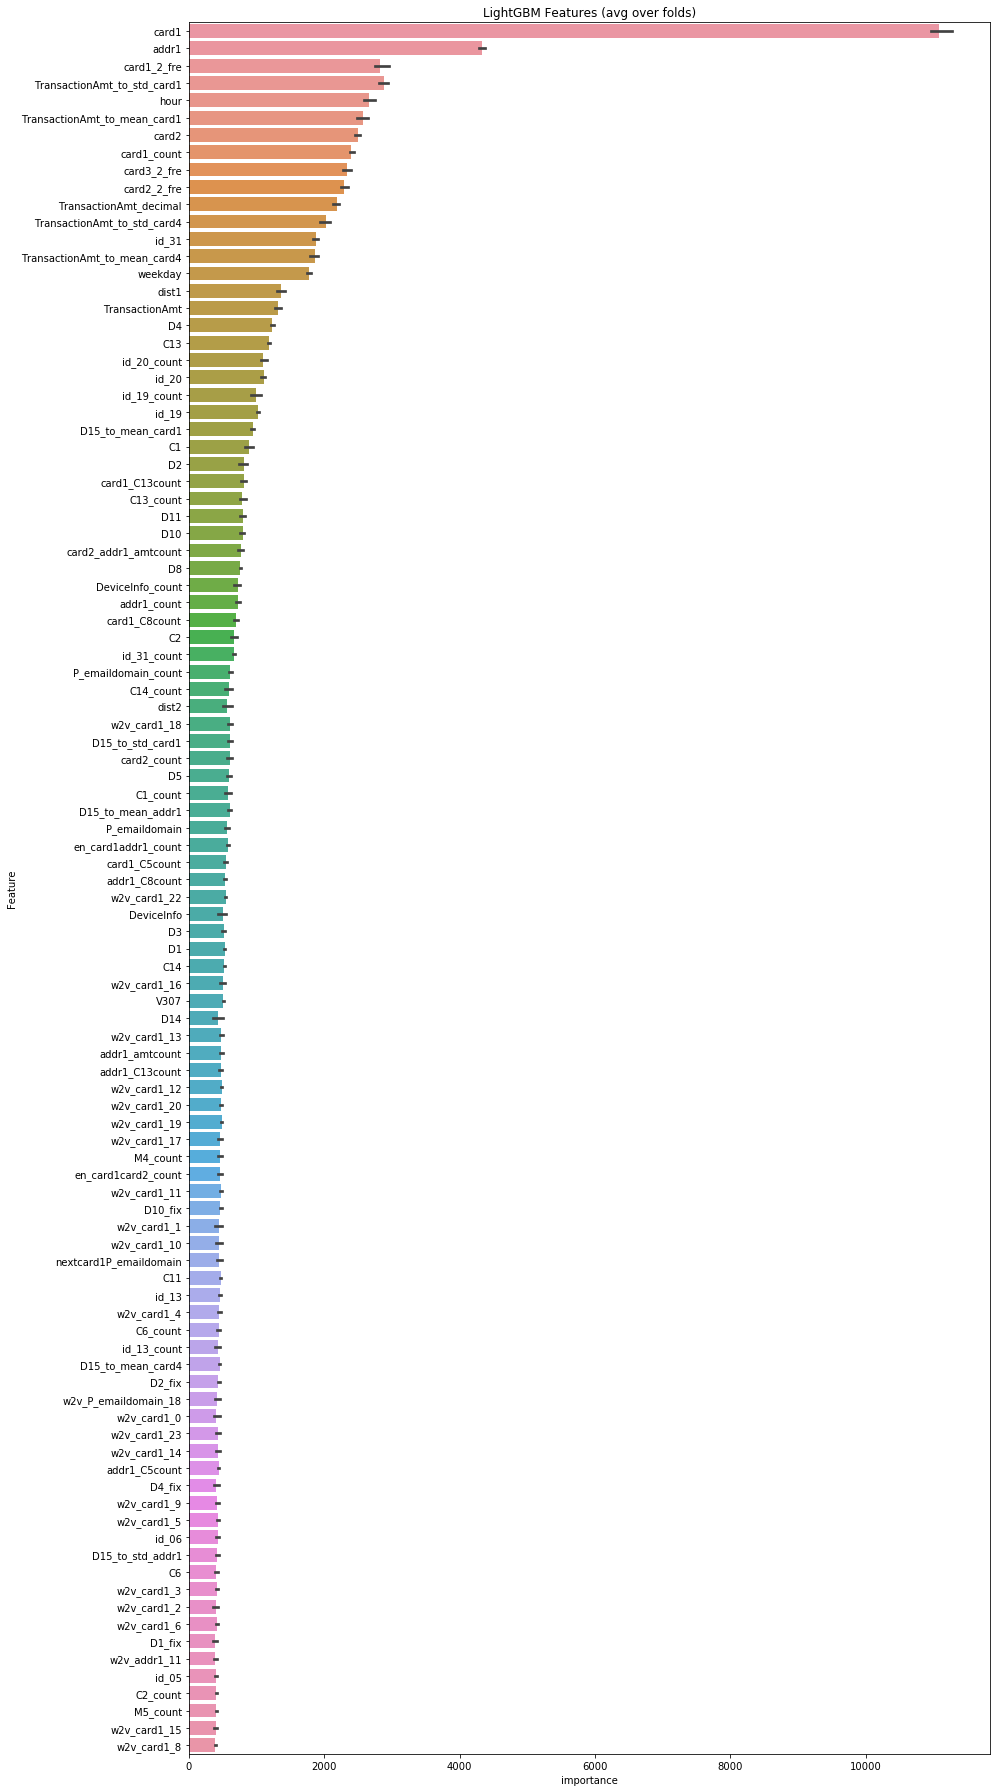

In [33]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [34]:
import catboost as cb
from catboost import CatBoostClassifier,Pool

# os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
print(len(features))
cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
       and x not in train_f5.columns and x not in train_f6.columns]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 700
y_preds3_temp = np.zeros(X_test.shape[0])
y_preds3_temp2 = np.zeros(X_test.shape[0])

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,min_data_in_leaf=15,l2_leaf_reg=3.0
                                ,task_type = "GPU",devices = ["1"]
                               )
    if debug:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
#         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    best_iter = model.get_best_iteration()
    best_iter = 0
    print(best_iter)
    y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
    y_preds3 += temp/ folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
        best_iter = num_rounds - 100
        y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
        best_iter = num_rounds - 200
        y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

506
['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'nextcard1P_emaildomain', 'nextcard2P_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6123704	total: 1.39s	remaining: 16m 8s
30:	learn: 0.0899633	total: 41.2s	remaining: 14m 48s
60:	learn: 0.0639265	total: 1m 22s	remaining: 14m 20s
90:	learn: 0.0548519	total: 2m 3s	remaining: 13m 47s
120:	learn: 0.0496102	total: 2m 44s	remaining: 13m 8s
150:	learn: 0.0456667	total: 3m 25s	remaining: 12m 27s
180:	learn: 0.0433073	total: 4m 6s	remaining: 11m 46s
210:	learn: 0.0415608	total: 4m 46s	remaining: 11m 3s
240:	learn: 0.0395259	total: 5m 27s	remaining: 10m 23s
270:	learn: 0.0379794	total: 6m 7s	remaining: 9m 41s
300:	learn: 0.0362412	total: 6m 48s	remaining: 9m 1s
330:	learn: 0.0348420	total: 7m 28s	remaining: 8m 20s
360:	learn: 0.0338643	total: 8m 8s	remaining: 7m 38s
390:	learn: 0.0329400	total: 8m 48s	remaining: 6m 58s
420:	learn: 0.0316370	total: 9m 29s	remaining: 6m 17s
450:	learn: 0.0305623	total:

In [35]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


In [36]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*1.5 + y_preds*1.5 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5))
    

In [37]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['y_preds3'] = y_preds3
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline14.csv')
else:
    sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds11*1.4 + y_preds*1.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/5
    sample_submission.to_csv('simple_ensemble14.csv')
